# Prediksi Keterlambatan Pengiriman Produk Menggunakan Model XGBoost dan LightGBM

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import pickle

# 1. Memuat Data

In [2]:
# 1. Memuat Data
data = pd.read_csv('dataset/Train.csv')

# 2. Eksplorasi Data
- Menggunakan fungsi info() untuk mendapatkan informasi tipe data dan jumlah nilai non-null pada setiap kolom.
- Fungsi head() digunakan untuk menampilkan 5 baris pertama dari dataset.

In [3]:
# 2. Eksplorasi Data
print("Informasi Data:")
print(data.info())

Informasi Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None


In [4]:
print("\nLima Baris Pertama Data:")
print(data.head())



Lima Baris Pertama Data:
   ID Warehouse_block Mode_of_Shipment  Customer_care_calls  Customer_rating  \
0   1               D           Flight                    4                2   
1   2               F           Flight                    4                5   
2   3               A           Flight                    2                2   
3   4               B           Flight                    3                3   
4   5               C           Flight                    2                2   

   Cost_of_the_Product  Prior_purchases Product_importance Gender  \
0                  177                3                low      F   
1                  216                2                low      M   
2                  183                4                low      M   
3                  176                4             medium      M   
4                  184                3             medium      F   

   Discount_offered  Weight_in_gms  Reached.on.Time_Y.N  
0                44 

# 3. Memeriksa Distribusi Variabel Target
- Menampilkan distribusi dari variabel target Reached.on.Time_Y.N, yaitu apakah produk tiba tepat waktu (1) atau terlambat (0).
- normalize=True menampilkan proporsi untuk setiap kategori (0 dan 1).

In [5]:
# Memeriksa distribusi variabel target
print("\nDistribusi Variabel Target:")
print(data['Reached.on.Time_Y.N'].value_counts(normalize=True))


Distribusi Variabel Target:
Reached.on.Time_Y.N
1    0.596691
0    0.403309
Name: proportion, dtype: float64


# 4. Preprocessing Data
- Menghapus kolom ID yang tidak relevan untuk model.
- Menggunakan LabelEncoder untuk mengonversi kolom kategori (seperti Warehouse_block, Mode_of_Shipment, dll.) menjadi angka yang dapat diterima oleh model.
- Membuat dua fitur baru, yaitu Cost_per_Weight (biaya per unit berat) dan Discount_Impact (pengaruh diskon terhadap harga produk).

In [6]:
# Menghapus kolom ID karena tidak relevan
data = data.drop('ID', axis=1)

In [7]:
# Mengonversi variabel kategori menjadi numerik menggunakan LabelEncoder
label_cols = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
label_encoders = {col: LabelEncoder().fit(data[col]) for col in label_cols}
for col in label_cols:
    data[col] = label_encoders[col].transform(data[col])

In [8]:
# Membuat fitur baru
data['Cost_per_Weight'] = data['Cost_of_the_Product'] / data['Weight_in_gms']
data['Discount_Impact'] = data['Discount_offered'] / data['Cost_of_the_Product']

# 5. Mempersiapkan Fitur dan Target
- Kolom Reached.on.Time_Y.N dipisahkan sebagai variabel target (y), dan kolom lainnya dipilih sebagai fitur (X).
- Fitur numerik dinormalisasi menggunakan StandardScaler, yang membuat data memiliki rata-rata 0 dan standar deviasi 1.


In [9]:
# Pisahkan fitur dan target
X = data.drop('Reached.on.Time_Y.N', axis=1)
y = data['Reached.on.Time_Y.N']

In [10]:
# Normalisasi fitur numerik
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Menyeimbangkan Data dengan SMOTE-ENN
- SMOTE-ENN digunakan untuk menangani masalah ketidakseimbangan kelas pada dataset. SMOTE menghasilkan data sintetis untuk kelas minoritas, sedangkan ENN menghapus contoh yang salah klasifikasi.
- Hasilnya adalah dataset yang seimbang dengan variabel X_res dan y_res.


In [11]:
# Menyeimbangkan data dengan SMOTE-ENN
smote_enn = SMOTEENN(random_state=42)
X_res, y_res = smote_enn.fit_resample(X_scaled, y)

# 7. Split Dataset ke Training dan Test Set
- Dataset dibagi menjadi dua bagian: data training (80%) dan data testing (20%) menggunakan fungsi train_test_split.
- Parameter stratify=y_res memastikan distribusi kelas target tetap seimbang pada kedua set.

In [12]:
# Split dataset menjadi train dan test set
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

# 8. Modeling dengan XGBoost
- Model XGBoost diinisialisasi dan digunakan untuk klasifikasi.
- Grid Search digunakan untuk melakukan pencarian parameter terbaik untuk model XGBoost menggunakan beberapa kombinasi hyperparameter, dan hasil terbaik disimpan dalam best_xgb_model.

In [13]:
# Inisialisasi model XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

In [14]:
# Hyperparameter tuning untuk XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [15]:
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)
best_xgb_model = grid_search_xgb.best_estimator_
print("Hyperparameters terbaik untuk XGBoost:", grid_search_xgb.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Hyperparameters terbaik untuk XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}


# 9. Evaluasi Model XGBoost
- Prediksi dilakukan menggunakan model XGBoost dan hasilnya dievaluasi menggunakan matriks kebingungannya (confusion matrix), laporan klasifikasi, akurasi, dan skor ROC AUC.


In [16]:
# Evaluasi XGBoost
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

In [17]:
print("\nConfusion Matrix - XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report - XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print("\nAccuracy Score - XGBoost:", accuracy_score(y_test, y_pred_xgb))
print("ROC AUC Score - XGBoost:", roc_auc_score(y_test, y_pred_prob_xgb))


Confusion Matrix - XGBoost:
[[617  10]
 [ 41 559]]

Classification Report - XGBoost:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       627
           1       0.98      0.93      0.96       600

    accuracy                           0.96      1227
   macro avg       0.96      0.96      0.96      1227
weighted avg       0.96      0.96      0.96      1227


Accuracy Score - XGBoost: 0.9584352078239609
ROC AUC Score - XGBoost: 0.9766188197767145


# 10. Modeling dengan LightGBM
- Sama seperti XGBoost, model LightGBM diinisialisasi dan dilakukan pencarian parameter terbaik menggunakan Grid Search.

In [18]:
# Inisialisasi model LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)

In [19]:
# Hyperparameter tuning untuk LightGBM
param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [20, 31, 40],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

In [ ]:
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
grid_search_lgb.fit(X_train, y_train)
best_lgb_model = grid_search_lgb.best_estimator_
print("Hyperparameters terbaik untuk LightGBM:", grid_search_lgb.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


# 11. Evaluasi Model LightGBM
- Evaluasi dilakukan untuk model LightGBM menggunakan metrik yang sama seperti untuk XGBoost.


In [22]:
# Evaluasi LightGBM
y_pred_lgb = best_lgb_model.predict(X_test)
y_pred_prob_lgb = best_lgb_model.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix - LightGBM:")
print(confusion_matrix(y_test, y_pred_lgb))
print("\nClassification Report - LightGBM:")
print(classification_report(y_test, y_pred_lgb))
print("\nAccuracy Score - LightGBM:", accuracy_score(y_test, y_pred_lgb))
print("ROC AUC Score - LightGBM:", roc_auc_score(y_test, y_pred_prob_lgb))


Confusion Matrix - LightGBM:
[[619   8]
 [ 42 558]]

Classification Report - LightGBM:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       627
           1       0.99      0.93      0.96       600

    accuracy                           0.96      1227
   macro avg       0.96      0.96      0.96      1227
weighted avg       0.96      0.96      0.96      1227


Accuracy Score - LightGBM: 0.9592502037489813
ROC AUC Score - LightGBM: 0.9774029771398193


# 12. Threshold Tuning (XGBoost)
- Threshold tuning digunakan untuk menyesuaikan ambang batas antara dua kelas, dan dengan memilih threshold yang lebih rendah, model akan lebih sensitif terhadap kelas minoritas (misalnya, keterlambatan pengiriman).
- Penggunaan threshold yang lebih rendah seperti 0.3 dapat membantu menangkap lebih banyak contoh keterlambatan, namun dapat menyebabkan peningkatan jumlah false positive.
- Evaluasi dengan confusion matrix dan classification report membantu kita untuk menilai apakah perubahan threshold ini meningkatkan performa model, terutama dalam mengidentifikasi keterlambatan.

In [23]:
# Threshold tuning (XGBoost)
optimal_threshold = 0.3
y_pred_adjusted_xgb = (y_pred_prob_xgb >= optimal_threshold).astype(int)
print("\nConfusion Matrix - XGBoost (Adjusted Threshold):")
print(confusion_matrix(y_test, y_pred_adjusted_xgb))
print("\nClassification Report - XGBoost (Adjusted Threshold):")
print(classification_report(y_test, y_pred_adjusted_xgb))


Confusion Matrix - XGBoost (Adjusted Threshold):
[[608  19]
 [ 39 561]]

Classification Report - XGBoost (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       627
           1       0.97      0.94      0.95       600

    accuracy                           0.95      1227
   macro avg       0.95      0.95      0.95      1227
weighted avg       0.95      0.95      0.95      1227



# ROC Curve (XGBoost)

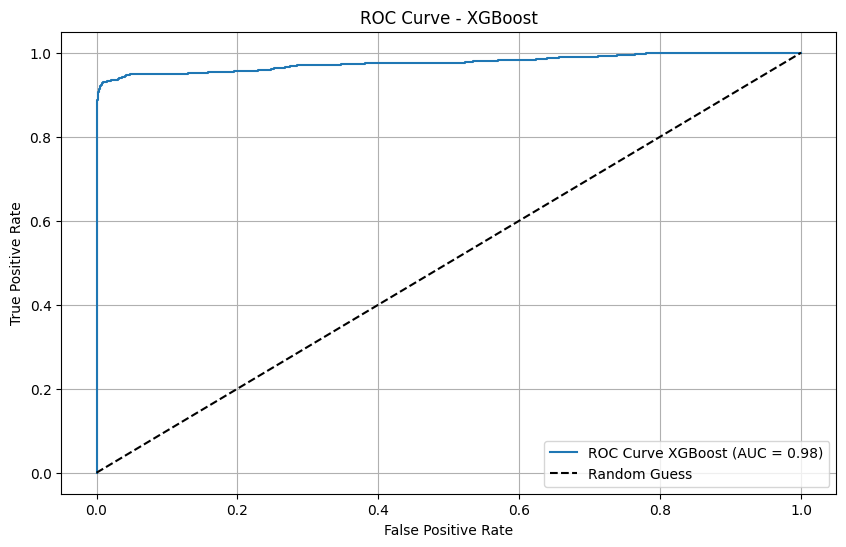

In [24]:
# ROC Curve (XGBoost)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_xgb)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve XGBoost (AUC = {roc_auc_score(y_test, y_pred_prob_xgb):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend()
plt.grid()
plt.show()

# Feature Importance (XGBoost)

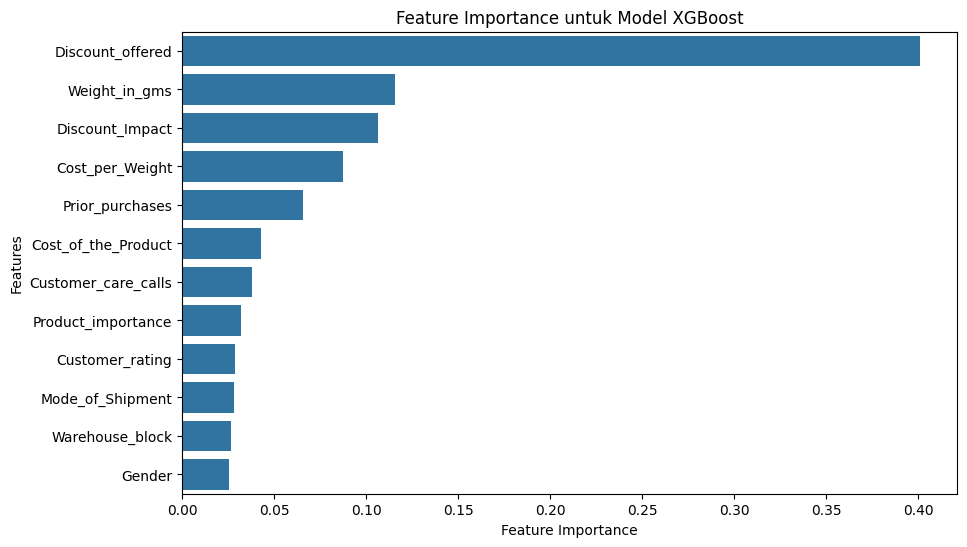

In [25]:
# Feature Importance (XGBoost)
feature_importance = pd.Series(best_xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance untuk Model XGBoost')
plt.show()

# 13.  Menyimpan dan Memuat Model
- Model yang telah dilatih disimpan dalam file .pkl menggunakan pickle. File ini nantinya bisa dimuat kembali untuk melakukan prediksi pada data baru.

In [26]:
# Menyimpan model LightGBM
with open('lightgbm_model.pkl', 'wb') as f:
    pickle.dump(best_lgb_model, f)

# Menyimpan model XGBoost
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(best_xgb_model, f)

print("Model berhasil disimpan!")


Model berhasil disimpan!


In [27]:
# Memuat model LightGBM
with open('lightgbm_model.pkl', 'rb') as f:
    loaded_lgb_model = pickle.load(f)

# Memuat model XGBoost
with open('xgboost_model.pkl', 'rb') as f:
    loaded_xgb_model = pickle.load(f)

print("Model LightGBM dan XGBoost berhasil dimuat!")

Model LightGBM dan XGBoost berhasil dimuat!


# 14. Prediksi Menggunakan Model

In [28]:
# Memuat model LightGBM
with open('lightgbm_model.pkl', 'rb') as f:
    loaded_lgb_model = pickle.load(f)

# Memuat model XGBoost
with open('xgboost_model.pkl', 'rb') as f:
    loaded_xgb_model = pickle.load(f)

# Contoh data baru untuk prediksi
new_data = pd.DataFrame({
    'Warehouse_block': [0], 
    'Mode_of_Shipment': [1],
    'Customer_care_calls': [4],
    'Customer_rating': [3],
    'Cost_of_the_Product': [200],
    'Prior_purchases': [2],
    'Product_importance': [0],
    'Gender': [1],
    'Discount_offered': [20],
    'Weight_in_gms': [1500],
    'Cost_per_Weight': [200 / 1500],
    'Discount_Impact': [20 / 200]
})

# Normalisasi data (sama seperti proses sebelumnya)
new_data_scaled = scaler.transform(new_data)

# Prediksi menggunakan LightGBM
prediction_lgb = loaded_lgb_model.predict(new_data_scaled)
print(f"Prediksi LightGBM: {'Tepat Waktu' if prediction_lgb[0] == 1 else 'Terlambat'}")

# Prediksi menggunakan XGBoost
prediction_xgb = loaded_xgb_model.predict(new_data_scaled)
print(f"Prediksi XGBoost: {'Tepat Waktu' if prediction_xgb[0] == 1 else 'Terlambat'}")


Prediksi LightGBM: Tepat Waktu
Prediksi XGBoost: Tepat Waktu


# Menyimpan File Scaler
- Di sini, Saya menyimpan objek scaler (misalnya, StandardScaler atau MinMaxScaler) ke dalam file dengan format pickle menggunakan pickle.dump.
- wb artinya file dibuka dalam mode write binary.
- Penyimpanan scaler ini memungkinkan Anda untuk menggunakan model normalisasi yang sama di masa depan tanpa perlu melatih ulang scaler.

In [29]:
# Simpan scaler ke file .pkl
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler berhasil disimpan!")


Scaler berhasil disimpan!


# Memuat Scaler dari File .pkl
- Pada bagian ini, Saya memuat kembali scaler yang telah disimpan sebelumnya menggunakan pickle.load.
- rb artinya file dibuka dalam mode read binary untuk membaca file yang telah disimpan.

In [30]:
# Memuat scaler
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Contoh data baru
new_data = pd.DataFrame({
    'Warehouse_block': [0],  # Ganti nilai sesuai dengan encoding yang Anda gunakan
    'Mode_of_Shipment': [1],
    'Customer_care_calls': [4],
    'Customer_rating': [3],
    'Cost_of_the_Product': [200],
    'Prior_purchases': [2],
    'Product_importance': [0],
    'Gender': [1],
    'Discount_offered': [20],
    'Weight_in_gms': [1500],
    'Cost_per_Weight': [200 / 1500],
    'Discount_Impact': [20 / 200]
})

# Normalisasi data
new_data_scaled = scaler.transform(new_data)
print("Data baru setelah normalisasi:")
print(new_data_scaled)


Data baru setelah normalisasi:
[[-1.56534517 -0.68290796 -0.04771132  0.00668917 -0.21216408 -1.02942377
  -2.13180168  1.00830799  0.40893983 -1.30496724  0.96770017  0.32112874]]
